## Graph Signal Interpolation


The goal of this assignment is to simulate the graph interpolation problem introduced in HW4. Some graph signal processing tasks are done by PyGSP package developed by LTS2 lab. The documentations can be found [here](https://pygsp.readthedocs.io/en/stable/index.html). However, this assignment is self-contained and you don't need any further knowledge of PyGSP.

In [1]:
# Installing PyGSP and cvxpy
! pip install --upgrade pip
! pip install PyGSP
! pip install cvxpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.3 MB/s eta 0:00:00


In [2]:
# Importing necessary packages
import pygsp as gsp
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Setting default plotting parameters
gsp.plotting.BACKEND = 'matplotlib'

# You can change figsize if you want.
plt.rcParams['figure.figsize'] = (10, 5)

First we need to define a graph. Here a sensor network graph with 100 sensors is used.

In [4]:
N = 100
# Define the graph
G = gsp.graphs.DavidSensorNet(N, seed=1)
G.estimate_lmax()

# You can access the grap laplacian using G.L
L = G.L.toarray()

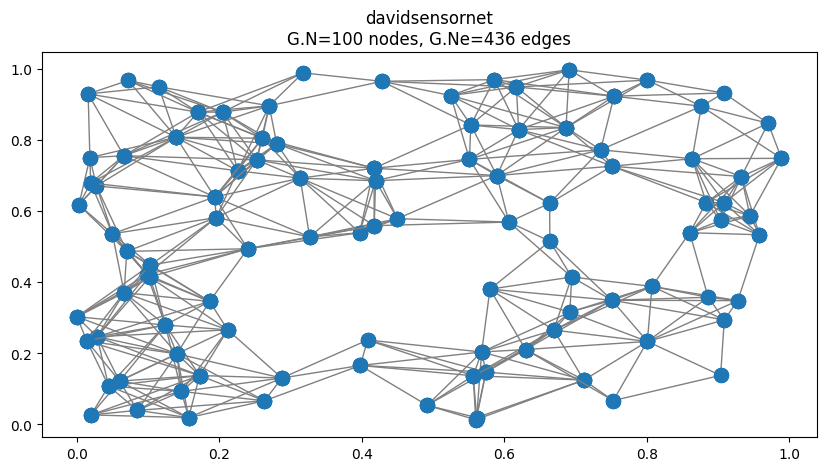

In [5]:
G.plot()

Now we need a smooth signal on the graph. First a non-smooth signal is defined and then it's filtered with a low-pass filter. Parameter τ controls bandwidth of the filter. As τ is increased, the output of the filter will be smoother.

In [6]:
non_smooth_signal = np.zeros((N,))

# non-smooth signal:
deltas = np.array([i for i in range(0, N, 10)])
non_smooth_signal[deltas] = 10

# low pass filter
lpf1 = gsp.filters.Heat(G, tau=5)
lpf2 = gsp.filters.Heat(G, tau=30)
lpf3 = gsp.filters.Heat(G, tau=100)

# filtering the signal
f1 = lpf1.filter(non_smooth_signal)
f2 = lpf2.filter(non_smooth_signal)
f3 = lpf3.filter(non_smooth_signal)

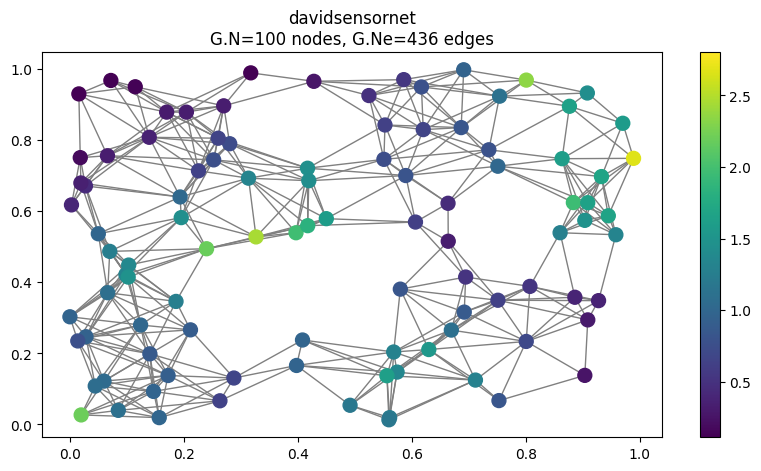

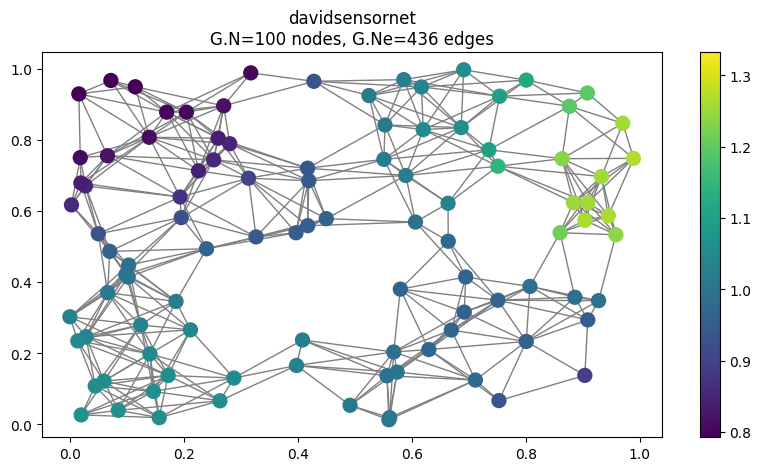

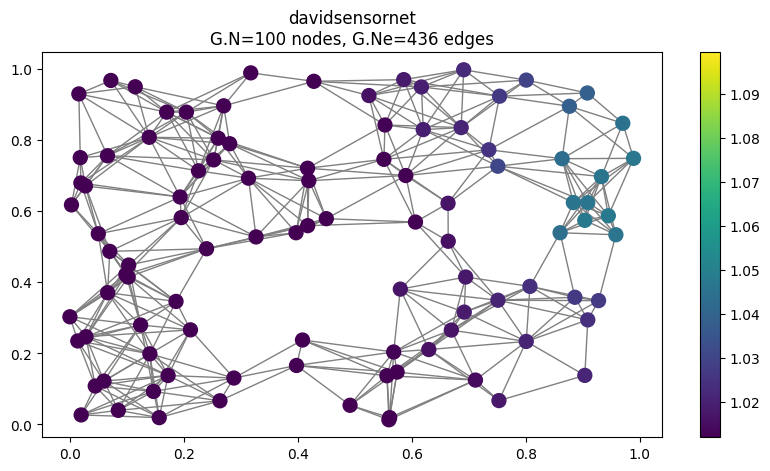

In [7]:
G.plot_signal(f1)
G.plot_signal(f2)
G.plot_signal(f3)

Defining B (repe. U) as the set of nodes with known (resp. unknown) signal values. You should use the signal values of nodes B to interpolate signal values on U.

In [8]:
U = [1, 32, 66, 89]
B = [i for i in range(N) if i not in U]

In [9]:
fU1 = f1[U]
fU2 = f2[U]
fU3 = f3[U]
fB1 = f1[B]
fB2 = f2[B]
fB3 = f3[B]

**What you should do:**


*   **Use cvxpy to interpolate f1, f2 and f3 on U.**
*   **Calculate the Mean Squared Error for each signal.**
*   **Discuss the effect of signal smoothness on recovery error.**
*   **Use your theoretical solution for interpolation.**
*   **Compare the theoretical solution with cvxpy .**

## My answer

Our objective is to minimize the graph laplacian-based cost function. To do this, we divide $L$ into blocks for known ($B$) and unknown ($U$) nodes. Then we use $L_U$ (submatrix for $U$) and $R$ (cross-term between $B$ and $U$).


In [10]:
def interpolate_signal(L, B, U, f_B, f_U_true):
    n = L.shape[0]
    L_U = L[np.ix_(U, U)]  # Submatrix for U
    R = L[np.ix_(U, B)]    # Cross-terms

    # Optimization variable: g_U (unknowns)
    g_U = cp.Variable(len(U))

    # Objective: g_U^T @ L_U @ g_U + 2 * g_U^T @ R @ f_B
    objective = cp.Minimize(cp.quad_form(g_U, L_U) + 2 * cp.matmul(g_U, R @ f_B))

    # Solve
    problem = cp.Problem(objective)
    problem.solve()

    # Compute MSE
    mse = np.mean((g_U.value - f_U_true)**2)
    return g_U.value, mse

Now we compute MSE for $f1$, $f2$, and $f3$:

In [11]:
gU1_cvxpy, mse1 = interpolate_signal(L, B, U, fB1, fU1)
gU2_cvxpy, mse2 = interpolate_signal(L, B, U, fB2, fU2)
gU3_cvxpy, mse3 = interpolate_signal(L, B, U, fB3, fU3)

Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point


The MSE values:

In [12]:
print("=== MSE Values ===")
print(f"MSE for τ=5 (Least Smooth): {mse1:.6f}")
print(f"MSE for τ=30 (Moderately Smooth): {mse2:.6f}")
print(f"MSE for τ=100 (Smoothest): {mse3:.6f}")

=== MSE Values ===
MSE for τ=5 (Least Smooth): 0.006776
MSE for τ=30 (Moderately Smooth): 0.000023
MSE for τ=100 (Smoothest): 0.000000


The closed-loop solution for $g_U$ is:
$$g_U = -L_U^{-1}Rf_B$$

In [13]:
def theoretical_solution(L, B, U, f_B):
    L_U = L[np.ix_(U, U)]
    R = L[np.ix_(U, B)]
    g_U = -np.linalg.inv(L_U) @ R @ f_B
    return g_U

In [14]:
# Compute theoretical predictions
gU1_theory = theoretical_solution(L, B, U, fB1)
gU2_theory = theoretical_solution(L, B, U, fB2)
gU3_theory = theoretical_solution(L, B, U, fB3)

# Compute MSE for theoretical solution
mse1_theory = np.mean((gU1_theory - fU1)**2)
mse2_theory = np.mean((gU2_theory - fU2)**2)
mse3_theory = np.mean((gU3_theory - fU3)**2)

# Print results
print("\n=== Theoretical Solution MSE ===")
print(f"Theoretical MSE for τ=5: {mse1_theory:.6f}")
print(f"Theoretical MSE for τ=30: {mse2_theory:.6f}")
print(f"Theoretical MSE for τ=100: {mse3_theory:.6f}")


=== Theoretical Solution MSE ===
Theoretical MSE for τ=5: 0.006776
Theoretical MSE for τ=30: 0.000023
Theoretical MSE for τ=100: 0.000000


Now to compare the results:

In [15]:
# Compute differences between CVXPY and theoretical solutions
diff1 = np.linalg.norm(gU1_cvxpy - gU1_theory)
diff2 = np.linalg.norm(gU2_cvxpy - gU2_theory)
diff3 = np.linalg.norm(gU3_cvxpy - gU3_theory)

print("\n=== CVXPY vs. Theoretical Differences ===")
print(f"Difference for τ=5: {diff1:.2e}")
print(f"Difference for τ=30: {diff2:.2e}")
print(f"Difference for τ=100: {diff3:.2e}")


=== CVXPY vs. Theoretical Differences ===
Difference for τ=5: 6.50e-06
Difference for τ=30: 5.64e-06
Difference for τ=100: 5.60e-06


## Bonus Part

(Bonus) Usually signals are a result of physical measurements and hence are noisy. In such cases it isn't reasonable to have an equality constraint of $g_B = f_B$. One approach that is used in such cases is to solve the following optimzation problem called Tikhonov regularization:
$$\min_{g \in \mathbb{R}^n} g^TLg + \gamma ||Mg - f_B||_2^2$$
Where $M\in\mathbb{R}^{|B|\times n}$ is a downsampling matrix ($Mf = f_B$).

**What you should do:**


*   **Add a gaussian noise to the signals.**
*   **Recover the signals by solving Tikhonov regularization using cvxpy .**
*   **Report the MSE.**
*   **Try different noise levels.**
*   **Report the MSE for different noise levels.**
*   **Discuss the effect of SNR on recovery error.**
*   **Try different values for $\gamma$ and again compare the results (You can plot MSE vs. $γ$).**

The problem becomes in the form:
$$min_{y\in R^n} g^TLg+γ||Mg-f_B||^2_2$$

We add the guassian noise first with the function below:

In [16]:
def add_noise(f_B, snr_db):
    signal_power = np.mean(f_B**2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), f_B.shape)
    return f_B + noise

Now we define the function to solve the Tikhonov regularization:

In [17]:
def tikhonov_solution(L, B, U, f_B_noisy, gamma):
    n = L.shape[0]
    M = np.zeros((len(B), n))
    M[np.arange(len(B)), B] = 1  # Sampling matrix

    g = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(g, L) + gamma * cp.sum_squares(M @ g - f_B_noisy))
    problem = cp.Problem(objective)
    problem.solve()
    return g.value[U]

To test and analyze the results, we try with different SNR levels (e.g., 20 dB, 10 dB, 5 dB) and then plot the MSE vs γ.

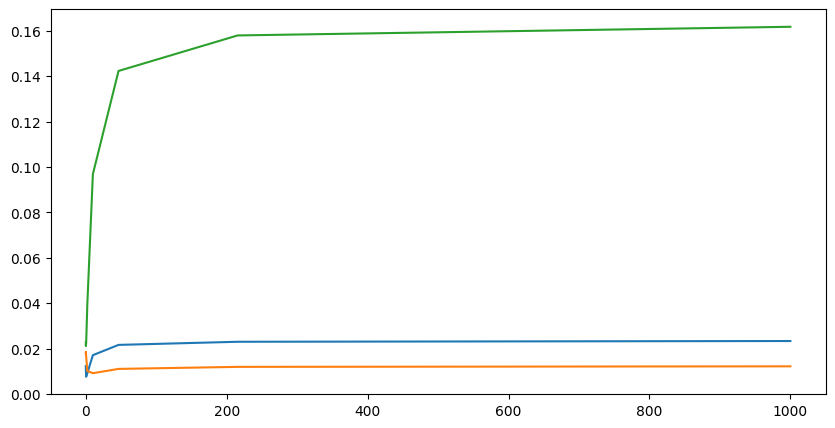

In [18]:
snr_levels = [20, 10, 5]
gamma_values = np.logspace(-3, 3, 10)  # Log-spaced γ values

for snr in snr_levels:
    fB1_noisy = add_noise(fB1, snr)
    mse_list = []
    for gamma in gamma_values:
        gU_tikhonov = tikhonov_solution(L, B, U, fB1_noisy, gamma)
        mse = np.mean((gU_tikhonov - fU1)**2)
        mse_list.append(mse)
    plt.plot(gamma_values, mse_list, label=f'SNR={snr} dB')